# Global importance analysis of motif number and identity
Visualize the results of global importance analysis and compare the results to experimental data.

Required inputs:
* `synthetic_insertion_preds.txt`: the predicted activity of each background sequence on its own and with various combinations of motifs inserted at fixed positions. Bonus second file which contains a second set of positions, but these are not used in the manuscript.
* `activity_summary_stats_and_metadata.txt`
* `eLifeMotifs.meme`: the 8 PWMs used in the Friedman et al., eLife, 2021 study.

Outputs:
* `motifNumberImportance_{tf names}_{FirstSet,SecondSet}.svg`: violin plots of the predicted importance of various numbers and combinations of motifs.
* `gcVs4Crx.svg`: scatterplot of the predicted effect of four consensus CRX motifs vs. the GC content of the background sequence.
* `gcVs4Background.svg`: scatterplot of the predicted *activity* of each background sequence vs. its GC content.
* `genomicMotifCountVsActivity.svg`: violin plot of the activity of genomic sequences from the eLife study containing exactly 1 CRX motif, and either NRL or RORB motifs, and no detectable instances of the other 5 motifs.
* `strongEnhancerMutate{NRL,NDF1,RORB,MAZ,MEF2D}.svg`: violin plots of the observed effects of scrambling all instances of a TF motif in all genomic strong enhancers, stratified by the number of motifs scrambled. Bonus figures not used in the manuscript are generated.

In [1]:
import os
import sys
import itertools
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import selene_sdk
from deeplift.dinuc_shuffle import dinuc_shuffle

from src.mpra_tools import fasta_utils, loaders, modeling, predicted_occupancy, plot_utils

from IPython.display import display

figures_dir = "Figures"
plot_utils.set_manuscript_params()

/ref/bclab/software/dlyon/spack/opt/spack/linux-rocky8-x86_64/gcc-8.5.0/miniconda3-4.10.3-2vnv4wet2ju7hlsej5cgneo6trlw7lly/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Helper functions.

In [2]:
tf_names = [
    "CRX",
    "GFI1",
    "MAZ",
    "MEF2D",
    "NDF1",
    "NRL",
    "RAX",
    "RORB",
]

# Read in big table and separate out info about sequence used
def load_table(f):
    importance_df = loaders.load_data(f)
    shuffle_seq = importance_df["shuffle_seq"]
    gc_content = importance_df["gc_content"]
    importance_df = importance_df.drop(columns=["shuffle_seq", "gc_content"])
    return importance_df, shuffle_seq, gc_content

# Generate lookup table to decode columns
# Info about number of sites for each TF and the total number
def get_decoder(df):
    column_str_method = df.columns.str
    column_lookup = {
        tf: column_str_method.count(tf)
        for tf in tf_names
    }
    column_lookup["Total"] = column_str_method.split(",").str.len()
    column_lookup = pd.DataFrame(column_lookup, index=df.columns)
    # Need to manually adjust background because of how things were encoded
    column_lookup.loc["background", "Total"] = 0
    display(column_lookup.head())
    return column_lookup
        
# Massage importance scores for plotting
def df_to_groupby(df):
    return df.melt(ignore_index=False).groupby("variable")

# Plot horizontal lines for the class cutoffs
def plot_cutoffs(ax):
    for y in [-1, 1, loaders.get_strong_cutoff()]:
        ax.axhline(y, color="k", linestyle="--")

FirstSet


,CRX,GFI1,MAZ,MEF2D,NDF1,NRL,RAX,RORB,Total
background,0,0,0,0,0,0,0,0,0
78CRX,1,0,0,0,0,0,0,0,1
78GFI1,0,1,0,0,0,0,0,0,1
78MAZ,0,0,1,0,0,0,0,0,1
78MEF2D,0,0,0,1,0,0,0,0,1


,count,mean,std,min,25%,50%,75%,max
CRX,,,,,,,,
1,4658.0,-0.262598,0.359747,-2.449463,-0.413129,-0.185914,-0.047626,1.390632
2,4658.0,-0.805384,0.718848,-4.509752,-1.309786,-0.711955,-0.265819,1.197061
3,4658.0,-1.711030,0.816777,-5.062094,-2.298203,-1.780816,-1.147218,0.957469
4,4658.0,-2.600408,0.865405,-6.142138,-3.163848,-2.710081,-2.117560,0.732507


,count,mean,std,min,25%,50%,75%,max
GFI1,,,,,,,,
0,4658.0,-0.262598,0.359747,-2.449463,-0.413129,-0.185914,-0.047626,1.390632
1,4658.0,-0.711304,0.562451,-4.063200,-1.025200,-0.584444,-0.317548,1.306057
2,4658.0,-0.934783,0.616013,-4.035906,-1.320702,-0.817837,-0.472796,1.399235
3,4658.0,-1.570683,0.815458,-4.509377,-2.133313,-1.516321,-0.935944,1.032175


,count,mean,std,min,25%,50%,75%,max
MAZ,,,,,,,,
0,4658.0,-0.262598,0.359747,-2.449463,-0.413129,-0.185914,-0.047626,1.390632
1,4658.0,0.019843,0.376050,-2.160570,-0.165010,0.039748,0.236798,1.653145
2,4658.0,0.124133,0.392307,-2.017701,-0.097965,0.125831,0.354150,2.987476
3,4658.0,0.369695,0.467774,-2.329325,0.088309,0.363582,0.639137,3.002701


,count,mean,std,min,25%,50%,75%,max
MEF2D,,,,,,,,
0,4658.0,-0.262598,0.359747,-2.449463,-0.413129,-0.185914,-0.047626,1.390632
1,4658.0,1.699393,0.475975,-0.275958,1.405682,1.707765,2.000826,4.028336
2,4658.0,2.230221,0.539314,0.213044,1.891607,2.239743,2.563902,5.064269
3,4658.0,3.097376,0.575578,0.080377,2.758659,3.102821,3.437894,5.923088


,count,mean,std,min,25%,50%,75%,max
NDF1,,,,,,,,
0,4658.0,-0.262598,0.359747,-2.449463,-0.413129,-0.185914,-0.047626,1.390632
1,4658.0,1.297466,0.442533,-0.415923,1.019626,1.300645,1.575659,3.731875
2,4658.0,2.259988,0.466343,0.355520,1.977374,2.258021,2.535313,5.029165
3,4658.0,3.463395,0.517270,1.281619,3.144835,3.450890,3.757525,6.363584


,count,mean,std,min,25%,50%,75%,max
NRL,,,,,,,,
0,4658.0,-0.262598,0.359747,-2.449463,-0.413129,-0.185914,-0.047626,1.390632
1,4658.0,0.308249,0.438831,-1.743388,0.038410,0.282200,0.565427,3.044229
2,4658.0,0.614468,0.477271,-1.339065,0.286953,0.573497,0.887258,3.643625
3,4658.0,1.073783,0.609537,-1.835904,0.654283,1.042002,1.448845,5.030308


,count,mean,std,min,25%,50%,75%,max
RAX,,,,,,,,
0,4658.0,-0.262598,0.359747,-2.449463,-0.413129,-0.185914,-0.047626,1.390632
1,4658.0,-0.525596,0.571799,-3.587191,-0.827555,-0.410424,-0.148134,2.033952
2,4658.0,-0.856155,0.723360,-4.119748,-1.312611,-0.771231,-0.325017,1.416430
3,4658.0,-1.282650,0.910229,-5.273061,-1.909892,-1.236394,-0.617378,1.483062


,count,mean,std,min,25%,50%,75%,max
RORB,,,,,,,,
0,4658.0,-0.262598,0.359747,-2.449463,-0.413129,-0.185914,-0.047626,1.390632
1,4658.0,1.876830,0.465216,-0.285022,1.582349,1.876521,2.161203,4.566744
2,4658.0,2.987167,0.473993,0.888327,2.700664,2.980149,3.265263,6.104316
3,4658.0,4.321122,0.540909,1.677138,3.993485,4.316909,4.625648,7.876117


GC content vs background, PCC=-0.0784590883779197, SCC=-0.07059954743110047
GC content vs 4 CRX, PCC=0.3258410115156023, SCC=0.33146692454788396
SecondSet


,CRX,GFI1,MAZ,MEF2D,NDF1,NRL,RAX,RORB,Total
background,0,0,0,0,0,0,0,0,0
8CRX,1,0,0,0,0,0,0,0,1
8GFI1,0,1,0,0,0,0,0,0,1
8MAZ,0,0,1,0,0,0,0,0,1
8MEF2D,0,0,0,1,0,0,0,0,1


,count,mean,std,min,25%,50%,75%,max
CRX,,,,,,,,
1,4658.0,-0.344507,0.201727,-1.497140,-0.438225,-0.308688,-0.210091,0.322015
2,4658.0,-1.001239,0.401660,-2.778383,-1.251288,-0.967310,-0.710382,0.237852
3,4658.0,-1.846315,0.538904,-3.889788,-2.197440,-1.825438,-1.477253,0.617376
4,4658.0,-2.752556,0.590685,-5.182875,-3.141343,-2.777065,-2.412171,0.848226


,count,mean,std,min,25%,50%,75%,max
GFI1,,,,,,,,
0,4658.0,-0.344507,0.201727,-1.497140,-0.438225,-0.308688,-0.210091,0.322015
1,4658.0,-0.487314,0.279432,-2.386968,-0.643005,-0.442222,-0.293760,0.674954
2,4658.0,-0.601539,0.357705,-2.260917,-0.795485,-0.554564,-0.354847,0.806310
3,4658.0,-0.777861,0.454357,-3.196945,-1.041970,-0.717522,-0.458021,1.179786


,count,mean,std,min,25%,50%,75%,max
MAZ,,,,,,,,
0,4658.0,-0.344507,0.201727,-1.497140,-0.438225,-0.308688,-0.210091,0.322015
1,4658.0,-0.292165,0.202250,-1.769407,-0.393678,-0.277752,-0.178012,1.134269
2,4658.0,-0.279524,0.244417,-1.435302,-0.417964,-0.279887,-0.151183,1.751441
3,4658.0,-0.235435,0.303131,-2.008706,-0.412592,-0.242703,-0.074620,2.477199


,count,mean,std,min,25%,50%,75%,max
MEF2D,,,,,,,,
0,4658.0,-0.344507,0.201727,-1.497140,-0.438225,-0.308688,-0.210091,0.322015
1,4658.0,0.335037,0.373896,-0.866389,0.089115,0.346311,0.569910,2.703004
2,4658.0,0.870086,0.469759,-1.036663,0.579301,0.891324,1.169816,4.124372
3,4658.0,1.629377,0.536522,-0.599581,1.289639,1.646183,1.963536,4.669317


,count,mean,std,min,25%,50%,75%,max
NDF1,,,,,,,,
0,4658.0,-0.344507,0.201727,-1.497140,-0.438225,-0.308688,-0.210091,0.322015
1,4658.0,0.375523,0.343639,-0.699096,0.145893,0.358899,0.585265,2.640678
2,4658.0,1.202023,0.409800,-0.416300,0.940435,1.195142,1.439803,4.485212
3,4658.0,2.195304,0.471888,0.689911,1.892326,2.186010,2.470225,5.482596


,count,mean,std,min,25%,50%,75%,max
NRL,,,,,,,,
0,4658.0,-0.344507,0.201727,-1.497140,-0.438225,-0.308688,-0.210091,0.322015
1,4658.0,-0.163092,0.239623,-1.621763,-0.290524,-0.176679,-0.053586,1.597510
2,4658.0,0.008792,0.320682,-1.064750,-0.196045,-0.046330,0.166546,2.813459
3,4658.0,0.250778,0.417735,-1.780389,-0.040381,0.188555,0.487044,3.457321


,count,mean,std,min,25%,50%,75%,max
RAX,,,,,,,,
0,4658.0,-0.344507,0.201727,-1.497140,-0.438225,-0.308688,-0.210091,0.322015
1,4658.0,-0.564774,0.344683,-2.607190,-0.740073,-0.495345,-0.334743,0.865550
2,4658.0,-0.853432,0.515235,-3.437529,-1.137350,-0.769597,-0.491994,0.987550
3,4658.0,-1.167455,0.670481,-3.865544,-1.577663,-1.080375,-0.689632,1.057972


,count,mean,std,min,25%,50%,75%,max
RORB,,,,,,,,
0,4658.0,-0.344507,0.201727,-1.497140,-0.438225,-0.308688,-0.210091,0.322015
1,4658.0,0.577695,0.356262,-0.553875,0.344195,0.576260,0.790193,3.164709
2,4658.0,1.535058,0.426025,0.030344,1.261274,1.524873,1.785216,4.654013
3,4658.0,2.708628,0.479351,0.386134,2.409767,2.693565,2.987218,5.926179


GC content vs background, PCC=-0.0784590883779197, SCC=-0.07059954743110047
GC content vs 4 CRX, PCC=0.22795485626536244, SCC=0.23574505622636746


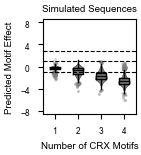

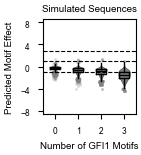

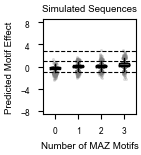

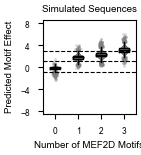

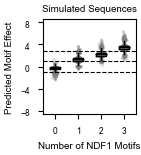

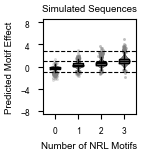

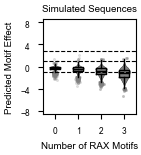

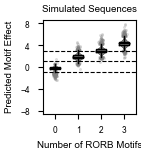

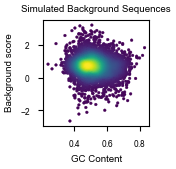

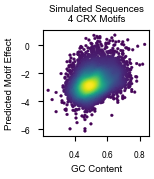

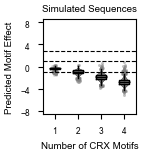

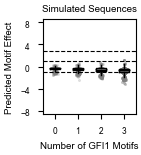

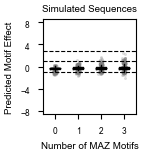

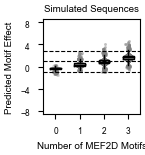

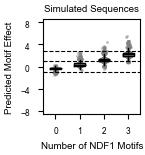

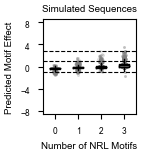

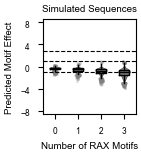

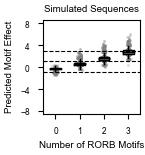

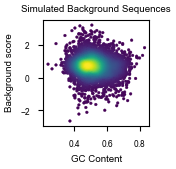

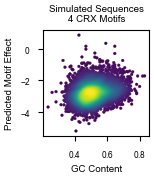

In [3]:
position_sets = [("FirstSet", "78CRX"), ("SecondSet", "^8CRX")]
# ymin = 100
# ymax = -100
ylim = [-8.562703622111469, 8.52317672]

for (i, crx_position) in position_sets:
    print(i)
    importance_df, shuffle_seq, gc_content = load_table(os.path.join("ImportanceAnalysis", "MotifCombos", i, "synthetic_insertion_preds.txt"))
    background = importance_df["background"]
    column_lookup = get_decoder(importance_df)
    
    # Plot effect of each TF
    for tf in tf_names:
        if tf == "CRX":
            column_mask = column_lookup.index.str.contains(crx_position) & (column_lookup["CRX"] == column_lookup["Total"])
        else:
            column_mask = column_lookup.index.str.contains(crx_position) &\
                (
                    (column_lookup["CRX"] == 1) &
                    (column_lookup[["CRX", tf]].sum(axis=1) == column_lookup["Total"])
                )
        crx_add_tf = importance_df.loc[:, column_mask]
        crx_add_tf_vs_bkgd = crx_add_tf.subtract(background, axis="index")
        # Count number of sites for TF2
        crx_add_tf_vs_bkgd = crx_add_tf_vs_bkgd.rename(columns=lambda x: len(re.findall(tf, x)))
        grouper = df_to_groupby(crx_add_tf_vs_bkgd)
        display(grouper["value"].describe().rename_axis(index=tf))

        fig = plot_utils.violin_plot_groupby(
            grouper["value"],
            None,
            figax=plt.subplots(figsize=plot_utils.get_figsize(0.2, 1))
        )
        ax = fig.axes[0]
        ax.set_yticks(np.arange(-8, 9, 4))
        ax.set_xlabel(f"Number of {tf} Motifs")
        ax.set_ylabel("Predicted Motif Effect")
        ax.set_title("Simulated Sequences")
        plot_cutoffs(ax)
        ax.set_ylim(ylim)
        
        # limits = ax.get_ylim()
        # ymin = min(ymin, limits[0])
        # ymax = max(ymax, limits[1])
        
        plot_utils.save_fig(fig, os.path.join(figures_dir, f"motifNumberImportance_{tf}_{i}"))
    
    # Plot GC content vs background
    fig, ax, corrs = plot_utils.scatter_with_corr(
        gc_content,
        background,
        "GC Content",
        "Background score",
        colors="density",
        figax=plt.subplots(figsize=plot_utils.get_figsize(0.2, 1))
    )
    ax.set_title("Simulated Background Sequences")
    print(f"GC content vs background, PCC={corrs[0]}, SCC={corrs[1]}")
    plot_utils.save_fig(fig, os.path.join(figures_dir, f"gcVsBackground{i}"))
    
    # Do effect of 4 CRX vs background
    four_crx = importance_df.loc[:, (column_lookup["CRX"] == 4) & (column_lookup["Total"] == 4)]
    fig, ax, corrs = plot_utils.scatter_with_corr(
        gc_content,
        four_crx.squeeze() - background,
        "GC Content",
        "Predicted Motif Effect",
        colors="density",
        figax=plt.subplots(figsize=plot_utils.get_figsize(0.2, 1))
    )
    ax.set_title("Simulated Sequences\n4 CRX Motifs")
    print(f"GC content vs 4 CRX, PCC={corrs[0]}, SCC={corrs[1]}")
    plot_utils.save_fig(fig, os.path.join(figures_dir, f"gcVs4Crx{i}"))
    print("===================")
    
# print(ymin, ymax)

## Comparison to genomic sequences

Get original genomic sequences from the eLife study.

In [4]:
activity_df = loaders.load_data(
    os.path.join("Data", "activity_summary_stats_and_metadata.txt")
)
genomic_df = activity_df[activity_df["original_genomic"]].set_index("label")

Compute predicted occupancies.

In [5]:
ewms = predicted_occupancy.read_pwm_to_ewm(
    os.path.join("Data", "Downloaded", "eLifeMotifs.meme")
).rename(lambda x: x.split("_")[0])
mu = 9
occupancy_df = predicted_occupancy.all_seq_total_occupancy(
    genomic_df["sequence"],
    ewms,
    mu,
    convert_ewm=False
)

Find sequences with only one CRX, one CRX and some NRL, or one CRX and some RORB.

,count,mean,std,min,25%,50%,75%,max
1Crx,556.0,0.617798,1.802951,-8.482620,-0.573881,0.666861,1.838805,5.019890
1Crx+Nrl,86.0,1.341813,1.905223,-3.868089,0.113217,1.591542,2.521833,5.235753
1Crx+Rorb,29.0,1.936048,2.321240,-3.676100,-0.030911,2.718788,3.828175,5.239536


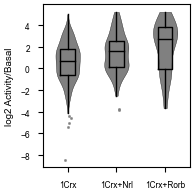

In [6]:
def annotate_motif_map(row):
    total = (row > 0.5).sum()
    if (0.5 < row["CRX"]) & (row["CRX"] <= 1.5):
        if total == 1:
            return "1Crx"
        elif (row["NRL"] > 0.5) & (total == 2):
            return "1Crx+Nrl"
        elif (row["RORB"] > 0.5) & (total == 2):
            return "1Crx+Rorb"
        else:
            return np.nan
    else:
        return np.nan
    
motif_groupings = occupancy_df.apply(annotate_motif_map, axis=1)
grouper = genomic_df.groupby(motif_groupings)
display(grouper["expression_log2"].describe())
fig = plot_utils.violin_plot_groupby(
    grouper["expression_log2"],
    "log2 Activity/Basal",
    figax=plt.subplots(figsize=plot_utils.get_figsize(0.3, 1))
)
plot_utils.save_fig(fig, os.path.join(figures_dir, "genomicMotifCountVsActivity"))

Plot effect sizes of deleting all motifs for a TF in all strong enhancers.

,count,mean,std,min,25%,50%,75%,max
NRL,,,,,,,,
1,193.0,0.561051,1.402104,-2.048648,-0.405026,0.237047,1.364031,4.906369
2,25.0,1.588346,2.184684,-1.667366,0.070251,0.712830,2.860115,5.487795
3,1.0,5.757839,NaN,5.757839,5.757839,5.757839,5.757839,5.757839


,count,mean,std,min,25%,50%,75%,max
NDF1,,,,,,,,
1,161.0,1.062838,1.475681,-1.475266,-0.007214,0.750697,1.846743,7.334941
2,18.0,1.234835,1.860445,-0.984444,-0.198743,0.798138,2.441889,4.829658
3,1.0,4.112778,NaN,4.112778,4.112778,4.112778,4.112778,4.112778
4,1.0,3.667327,NaN,3.667327,3.667327,3.667327,3.667327,3.667327


,count,mean,std,min,25%,50%,75%,max
RORB,,,,,,,,
1,178.0,1.327986,1.605778,-1.208525,0.007905,1.199401,2.169512,7.189979
2,9.0,3.209444,1.417348,1.139778,2.207923,3.241544,3.756999,5.959512
3,2.0,3.337911,0.651169,2.877465,3.107688,3.337911,3.568134,3.798357


,count,mean,std,min,25%,50%,75%,max
MAZ,,,,,,,,
1,120.0,0.001277,1.039642,-1.542228,-0.707125,-0.167822,0.273440,4.407896
2,31.0,-0.055251,1.403702,-1.551121,-0.973700,-0.513679,0.400248,4.247960
3,6.0,0.667527,1.139135,-0.558955,-0.077859,0.425772,1.147727,2.569930
4,2.0,1.760247,1.165511,0.936106,1.348176,1.760247,2.172317,2.584387
7,1.0,1.157593,NaN,1.157593,1.157593,1.157593,1.157593,1.157593


,count,mean,std,min,25%,50%,75%,max
MEF2D,,,,,,,,
1,25.0,1.064459,1.656841,-0.996574,-0.168162,0.716796,2.366690,5.550993
2,1.0,2.674496,NaN,2.674496,2.674496,2.674496,2.674496,2.674496


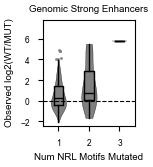

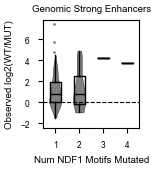

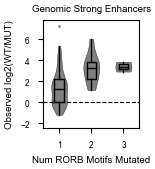

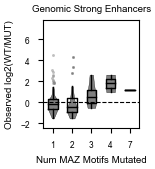

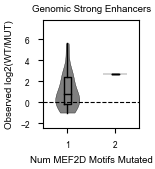

In [7]:
wt_df = activity_df[activity_df["original_genomic"]].set_index("label")
motif_deletion_df = activity_df[
    activity_df["rational_mutagenesis"] & activity_df["library"].str.contains("4|5")
]
# Parse out the designed deletion
designed_dels = motif_deletion_df["label"].str.split("HAND_").str[1]
# For each sequence, count the number of motifs mutated
deletion_counts = pd.DataFrame({
    tf: designed_dels.str.count(tf) for tf in tf_names
})
# Ignore cases when more than one type of motif was deleted
single_deletion_counts = deletion_counts[
    deletion_counts.max(axis=1) == deletion_counts.sum(axis=1)
]

single_deletion_df = motif_deletion_df.loc[single_deletion_counts.index]
# For each TF, calculate effect size of motifs relative to WT
for tf in ["NRL", "NDF1", "RORB", "MAZ", "MEF2D"]:
    tf_mut_df = single_deletion_df[single_deletion_counts[tf] > 0]
    mut_activity = tf_mut_df.set_index("immediate_precursor")["expression_log2"]
    wt_activity = wt_df.loc[mut_activity.index, "expression_log2"]
    effect_sizes = wt_activity - mut_activity
    # Group by number of motifs deleted
    grouper = effect_sizes.groupby(
        single_deletion_counts.loc[single_deletion_counts[tf] > 0, tf].values
    )
    display(grouper.describe().rename_axis(index=tf))
    fig = plot_utils.violin_plot_groupby(
        grouper,
        "Observed log2(WT/MUT)",
        figax=plt.subplots(figsize=plot_utils.get_figsize(0.22, 1))
    )
    ax = fig.axes[0]
    ax.set_xlabel(f"Num {tf} Motifs Mutated")
    ax.set_title("Genomic Strong Enhancers")
    # print(ax.get_ylim())
    ax.axhline(0, color="k", linestyle="--")
    ax.set_ylim((-2.4389725920684824, 7.775451125876526))
    
    plot_utils.save_fig(fig, os.path.join(figures_dir, f"strongEnhancerMutate{tf}"))
